# Inversion Notebook

In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import torch
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from lora_w2w import LoRAw2w
from utils import load_models, inference, save_model_w2w, save_model_for_diffusers
from inversion import invert
device = "cuda:0"

# Loading Base Models

In [2]:
unet, vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


1) mean is 99648 dimensional tensor of the mean for each parameter in the original LoRA space.
2) std is 99648 dimensional tensor of the standard deviation for each parameter in the original LoRA space.
3) v is 99648x10000 dimensional tensor used to project or unproject the weights onto principal component representation in w2w space or to unproject back into the LoRA space.
4) weight_dimensions is a dictionary of the dimensionality for each LoRA in the UNet. Used to save models in Diffusers pipeline format. 

In [3]:
mean = torch.load("../files/mean.pt").bfloat16().to(device)
std = torch.load("../files/std.pt").bfloat16().to(device)
v = torch.load("../files/V.pt").bfloat16().to(device)
weight_dimensions = torch.load("../files/weight_dimensions.pt")

Initialize optimization coefficients and load in. 10000 principal coefficients balances editability of the model and identity preservation. 

In [4]:
proj = torch.zeros(1,10000).bfloat16().to(device)
network = LoRAw2w( proj, mean, std, v[:, :10000], 
                    unet,
                    rank=1,
                    multiplier=1.0,
                    alpha=27.0,
                    train_method="xattn-strict"
                ).to(device, torch.bfloat16)


# Inversion

To run inversion, we provide a given image and an optional mask that can help guide reconstructing identity. You can provide a path to your own image and an optional mask. Refer to the folder structure for the example. If identity reconstruction is still lacking, we suggest increasing the number of epochs to 800.

In [5]:
network = invert(network=network, unet=unet, vae=vae, text_encoder=text_encoder, tokenizer=tokenizer, 
                 prompt = "sks person", noise_scheduler = noise_scheduler, epochs=400, 
                 image_path = "../inversion/images/real_image/real/", 
                 mask_path = "../inversion/images/real_image/mask.png", device = device)

100%|██████████| 400/400 [01:11<00:00,  5.58it/s]


Show Original Image

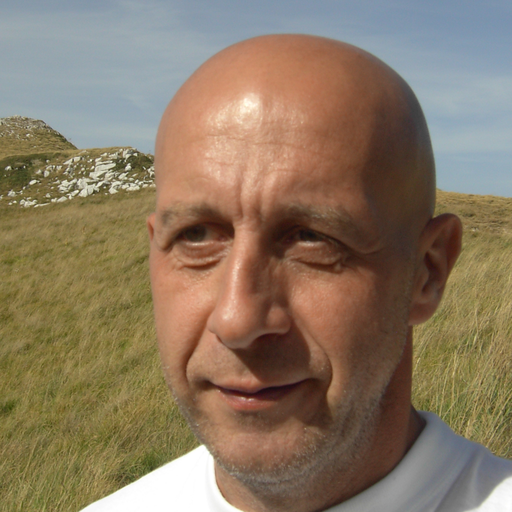

In [6]:
image = Image.open("images/real_image/real/im/43883.png")
image.show()

Generate samples from inverted identity

100%|██████████| 51/51 [00:03<00:00, 15.18it/s]


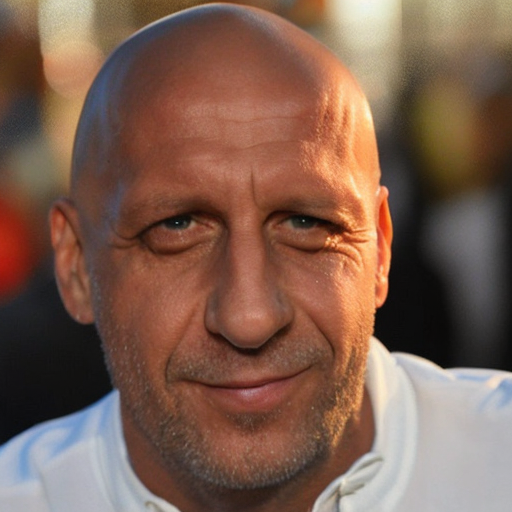

In [7]:
#inference parameters
prompt = "sks person" 
negative_prompt = "low quality, blurry, unfinished, cartoon"
batch_size = 1
height = 512
width = 512
guidance_scale = 2.5
seed = 1
ddim_steps = 50
# random seed generator
generator = torch.Generator(device=device)

#run inference
image = inference(network, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, seed, generator, device)

### display image
image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image.show()

Save model as a *w2w* model (just the 10000 coefficients)

In [8]:
save_model_w2w(network, path="../output/real_inversion_w2w")

You can also save it in a format compatible with Diffusers pipelines

In [10]:
save_model_for_diffusers(network,std, mean, v, weight_dimensions, path="../output/real_inversion_diffusers")